In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from tqdm import tqdm
import gsd.hoomd
from sklearn import cluster as cl
import scipy as sci

In [2]:
def unwrap_positions(positions, box, prev_positions=None):
    """
    Unwrap particle positions in a periodic box.
    
    Parameters:
    positions (np.ndarray): Particle positions (N x 3).
    box (np.ndarray): Box dimensions (3, corresponding to Lx, Ly, Lz).
    prev_positions (np.ndarray): Previous positions of particles (N x 3).
    
    Returns:
    np.ndarray: Unwrapped positions.
    """
    unwrapped_positions = np.copy(positions)
    box_lengths = np.array([box[0], box[1], box[2]])
    
    if prev_positions is not None:
        delta = positions - prev_positions
        delta -= np.round(delta / box_lengths) * box_lengths
        unwrapped_positions = prev_positions + delta
    
    return unwrapped_positions

def wrap_positions(positions, box):
    """
    Wrap particle positions back into the periodic box.
    
    Parameters:
    positions (np.ndarray): Particle positions (N x 3).
    box (np.ndarray): Box dimensions (3, corresponding to Lx, Ly, Lz).
    
    Returns:
    np.ndarray: Wrapped positions.
    """
    box_lengths = np.array([box[0], box[1], box[2]])
    wrapped_positions = positions - np.floor(positions / box_lengths + 0.5) * box_lengths
    
    return wrapped_positions

def center_trajectory(input_file, output_file, therm=0):
    # Open the input GSD file
    with gsd.hoomd.open(input_file, 'rb') as input_gsd:
        # Create the output GSD file
        with gsd.hoomd.open(output_file, 'wb') as output_gsd:
            # Initialize the previous positions array
            prev_positions = None
            box = input_gsd[0].configuration.box[:3]  # Get box dimensions (Lx, Ly, Lz)
            
            for frame in tqdm(input_gsd[therm:]):
                positions = frame.particles.position  # Get particle positions

                # Unwrap positions
                unwrapped_positions = unwrap_positions(positions, box, prev_positions)

                # Update prev_positions for the next frame
                prev_positions = np.copy(unwrapped_positions)
                
                # Shift positions to center the center of mass in the box
                centered_positions = unwrapped_positions - np.mean(unwrapped_positions, axis=0)

                # Wrap positions back into the box
                wrapped_positions = wrap_positions(centered_positions, box)

                # Update positions in the frame
                frame.particles.position = wrapped_positions

                # Append the frame to the output GSD file
                output_gsd.append(frame)
             

            
def process_trajectory(input_file, output_file, diss_time, therm=0):
    # Open the input GSD file
    with gsd.hoomd.open(input_file, 'rb') as input_gsd:
        # Create the output GSD file
        with gsd.hoomd.open(output_file, 'wb') as output_gsd:
            # Initialize the previous positions array
            prev_positions = None
            box = input_gsd[0].configuration.box[:3]  # Get box dimensions (Lx, Ly, Lz)
            
            for i,frame in enumerate(tqdm(input_gsd[therm:])):
                positions = frame.particles.position  # Get particle positions

                # Unwrap positions
                unwrapped_positions = unwrap_positions(positions, box, prev_positions)

                # Update prev_positions for the next frame
                prev_positions = np.copy(unwrapped_positions)
                
                # Shift positions to center the center of mass in the box
                if i<diss_time:
                    centered_positions = unwrapped_positions - np.mean(unwrapped_positions, axis=0)
                else:
                    centered_positions = unwrapped_positions - unwrapped_positions[30800]
                    
                # Wrap positions back into the box
                wrapped_positions = wrap_positions(centered_positions, box)

                # Update positions in the frame
                frame.particles.position = wrapped_positions

                # Append the frame to the output GSD file
                output_gsd.append(frame)

In [21]:
therm = 0
process_trajectory(input_file, output_file, therm)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [03:30<00:00,  7.13it/s]


### Clustering with DBSCAN

In [3]:
file_5ck1d = 'sim1_5-folded-ck1d_multi-tdp43_32b_dump_centered.gsd'
file_3ck1d = 'sim1_3-folded-ck1d_multi-tdp43_32b_dump_centered.gsd'


In [4]:
def nphospho_in_time(input_file, times):
    n_phospho_arr = np.zeros(len(times))
    with gsd.hoomd.open(input_file, 'rb') as input_gsd:
        print(len(input_gsd))
        for i, tt in enumerate(times):
            frame = input_gsd[int(tt)]
            n_phospho_arr[i] = np.sum(frame.particles.typeid==20)
            
    return n_phospho_arr

In [5]:
def condensate_size_from_dbscan(frame, n_enz, eps=1.0, min_sample=2):
    
    positions = frame.particles.position
    db = cl.DBSCAN(eps=eps, min_samples=min_sample).fit(positions)
    labels = db.labels_
    values, counts = np.unique(labels[:30800], return_counts=True)
    condensate_idx = np.argmax(counts)
    
    if np.array_equal(labels[30800:30800+n_enz],[values[condensate_idx]]*n_enz):
        return counts[condensate_idx]
    else:
        print(labels[30800:30800+n_enz],[condensate_idx])

        return 0

In [6]:
def chains_in_condensate(input_file, times, n_enz, eps=1.0, min_sample=2):

    n_chains_arr = np.zeros(len(times))
    n_phospho_arr = np.zeros(len(times))
    
    with gsd.hoomd.open(input_file, 'rb') as input_gsd:
        print(len(input_gsd))
        for i, tt in enumerate(tqdm(times)):
            frame = input_gsd[int(tt)]
            n_p_condensate = condensate_size_from_dbscan(frame, n_enz, eps, min_sample)
            n_chains_arr[i] = n_p_condensate/154.
            
            n_phospho_arr[i] = np.sum(frame.particles.typeid==20)
            
    return n_chains_arr, n_phospho_arr

In [7]:
def condensate_size_from_dbscan_pbc(frame, box, eps=1.0, min_sample=2):
    
    positions = frame.particles.position

    # Compute square distance matrix for all the selected particles
    total = []
    for d in range(positions.shape[1]):
        # Find all the 1-D distances
        pd = sci.spatial.distance.pdist(positions[:, d].reshape(positions.shape[0], 1))
        # Apply PBC
        pd[pd > box[d]*0.5] -= box[d]
        try:
            # Sum up individual components
            total += pd**2
        except Exception as e:
            # or define the sum variable if not defined previously
            total = pd ** 2
    # Transform the condensed distance matrix
    total = np.sqrt(total)
    # Transform into a square distance matrix
    square = sci.spatial.distance.squareform(total)
    print('hello')
    db = cl.DBSCAN(eps=eps, min_samples=min_sample).fit(square)
    labels = db.labels_
    values, counts = np.unique(labels[:30800], return_counts=True)
    condensate_idx = np.argmax(counts)
    
    if np.array_equal(labels[30800:30803],[values[condensate_idx]]*3):
        return counts[condensate_idx]
    else:
        print(labels[30800:30803],[condensate_idx])

        return 0

In [8]:
def chains_in_condensate_pbc(input_file, times, eps=1.0, min_sample=2):

    n_chains_arr = np.zeros(len(times))
    with gsd.hoomd.open(input_file, 'rb') as input_gsd:
        print(len(input_gsd))
        simBox = input_gsd[0].configuration.box # the production runs are NVT

        for i, tt in enumerate(tqdm(times)):
            frame = input_gsd[int(tt)]
            n_p_condensate = condensate_size_from_dbscan_pbc(frame, simBox, eps, min_sample)
            n_chains_arr[i] = n_p_condensate/154.
    return n_chains_arr

In [9]:
def enzymes_in_condensate(input_file, times, n_enz, eps=1.0, min_sample=2):

    n_chains_arr = np.zeros(len(times))
    
    with gsd.hoomd.open(input_file, 'rb') as input_gsd:
        print(len(input_gsd))
        for i, tt in enumerate(tqdm(times)):
            frame = input_gsd[int(tt)]
            n_chains_arr[i] = enzyme_in_condensate_from_dbscan(frame, n_enz, eps, min_sample)

    return n_chains_arr

In [10]:
def enzyme_in_condensate_from_dbscan(frame, n_enz, eps=1.0, min_sample=2):
    
    positions = frame.particles.position
    db = cl.DBSCAN(eps=eps, min_samples=min_sample).fit(positions)
    labels = db.labels_
    values, counts = np.unique(labels[:30800], return_counts=True)
    condensate_idx = np.argmax(counts)
    
    return np.sum(labels[30800:30800+n_enz]==np.array([values[condensate_idx]]*n_enz))

In [11]:
step = 20
times = np.arange(200,2500,step, dtype=int)-1
len(times)

115

In [12]:
nc_3ck1d, np_3ck1d = chains_in_condensate(file_3ck1d, times, 3)
nc_5ck1d, np_5ck1d = chains_in_condensate(file_5ck1d, times, 5)

2500


 83%|████████████████████████████████████████████████████████████████████████▋               | 95/115 [00:37<00:07,  2.81it/s]

[2 3 3] [4]


 83%|█████████████████████████████████████████████████████████████████████████▍              | 96/115 [00:38<00:06,  2.86it/s]

[2 0 0] [1]


 84%|██████████████████████████████████████████████████████████████████████████▏             | 97/115 [00:38<00:06,  2.87it/s]

[0 1 0] [1]


 87%|███████████████████████████████████████████████████████████████████████████▋           | 100/115 [00:39<00:05,  2.84it/s]

[3 2 2] [3]


 88%|████████████████████████████████████████████████████████████████████████████▍          | 101/115 [00:40<00:05,  2.76it/s]

[5 2 2] [3]


 94%|█████████████████████████████████████████████████████████████████████████████████▋     | 108/115 [00:42<00:02,  3.11it/s]

[ 3 10 17] [4]


 97%|███████████████████████████████████████████████████████████████████████████████████▉   | 111/115 [00:43<00:01,  3.13it/s]

[3 4 3] [5]


100%|███████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:44<00:00,  2.58it/s]


[2 2 3] [4]
2500


 61%|█████████████████████████████████████████████████████▌                                  | 70/115 [00:28<00:15,  2.86it/s]

[26  0  9  9  0] [1]


 62%|██████████████████████████████████████████████████████▎                                 | 71/115 [00:28<00:15,  2.88it/s]

[13 13  0 13 13] [1]


 64%|████████████████████████████████████████████████████████▋                               | 74/115 [00:30<00:14,  2.76it/s]

[4 4 4 5 4] [5]


 66%|██████████████████████████████████████████████████████████▏                             | 76/115 [00:30<00:13,  2.85it/s]

[ 1 12  1  3  3] [2]


 68%|███████████████████████████████████████████████████████████▋                            | 78/115 [00:31<00:12,  2.92it/s]

[0 1 0 0 1] [1]


 69%|████████████████████████████████████████████████████████████▍                           | 79/115 [00:31<00:12,  2.98it/s]

[0 1 0 0 1] [1]


 70%|█████████████████████████████████████████████████████████████▏                          | 80/115 [00:32<00:11,  2.97it/s]

[14  0 14  0  0] [1]


 70%|█████████████████████████████████████████████████████████████▉                          | 81/115 [00:32<00:11,  3.01it/s]

[0 0 0 1 0] [1]


 72%|███████████████████████████████████████████████████████████████▌                        | 83/115 [00:33<00:10,  3.04it/s]

[0 0 0 0 9] [1]


 76%|██████████████████████████████████████████████████████████████████▌                     | 87/115 [00:34<00:08,  3.19it/s]

[ 8 13  8 13  9] [14]


 79%|█████████████████████████████████████████████████████████████████████▋                  | 91/115 [00:35<00:07,  3.04it/s]

[0 4 0 0 0] [1]


 91%|███████████████████████████████████████████████████████████████████████████████▍       | 105/115 [00:39<00:03,  3.30it/s]

[ 7  7  7  7 59] [8]


 92%|████████████████████████████████████████████████████████████████████████████████▏      | 106/115 [00:40<00:02,  3.36it/s]

[ 7  7  7 39 50] [8]


 93%|████████████████████████████████████████████████████████████████████████████████▉      | 107/115 [00:40<00:02,  3.39it/s]

[ 16  16  16 129  46] [17]


 94%|█████████████████████████████████████████████████████████████████████████████████▋     | 108/115 [00:40<00:02,  3.34it/s]

[59 32 59 14  7] [15]


 95%|██████████████████████████████████████████████████████████████████████████████████▍    | 109/115 [00:41<00:01,  3.34it/s]

[17 19 17 30  7] [31]


 96%|███████████████████████████████████████████████████████████████████████████████████▏   | 110/115 [00:41<00:01,  3.27it/s]

[14 23 14 19 23] [24]


 97%|███████████████████████████████████████████████████████████████████████████████████▉   | 111/115 [00:41<00:01,  3.34it/s]

[ 1 59  1 33  9] [2]


 97%|████████████████████████████████████████████████████████████████████████████████████▋  | 112/115 [00:41<00:00,  3.37it/s]

[15 14 15 22 14] [23]


 98%|█████████████████████████████████████████████████████████████████████████████████████▍ | 113/115 [00:42<00:00,  3.38it/s]

[15 15 14 44 14] [16]


 99%|██████████████████████████████████████████████████████████████████████████████████████▏| 114/115 [00:42<00:00,  3.28it/s]

[1 1 1 4 1] [2]


100%|███████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:42<00:00,  2.68it/s]

[ 2  2  2 43  2] [3]


In [13]:
plt.style.use('rates_plot.mplstyle')

In [14]:
file = ''

nc_1ck1d = np.loadtxt(file+'size_cond_1-folded-ck1d_multi-tdp43.txt')
nc_3ck1d = np.loadtxt(file+'size_cond_3-folded-ck1d_multi-tdp43.txt')
nc_5ck1d = np.loadtxt(file+'size_cond_5-folded-ck1d_multi-tdp43.txt')
np_1ck1d = np.loadtxt(file+'nphospho_1-folded-ck1d_multi-tdp43.txt')
np_3ck1d = np.loadtxt(file+'nphospho_3-folded-ck1d_multi-tdp43.txt')
np_5ck1d = np.loadtxt(file+'nphospho_5-folded-ck1d_multi-tdp43.txt')


In [15]:
td_1 = np.where(nc_1ck1d/200 == 0.995)[0][0]
td_3 = np.where(nc_3ck1d/200 == 0.995)[0][0]
td_5 = np.where(nc_5ck1d/200 == 0.995)[0][0]

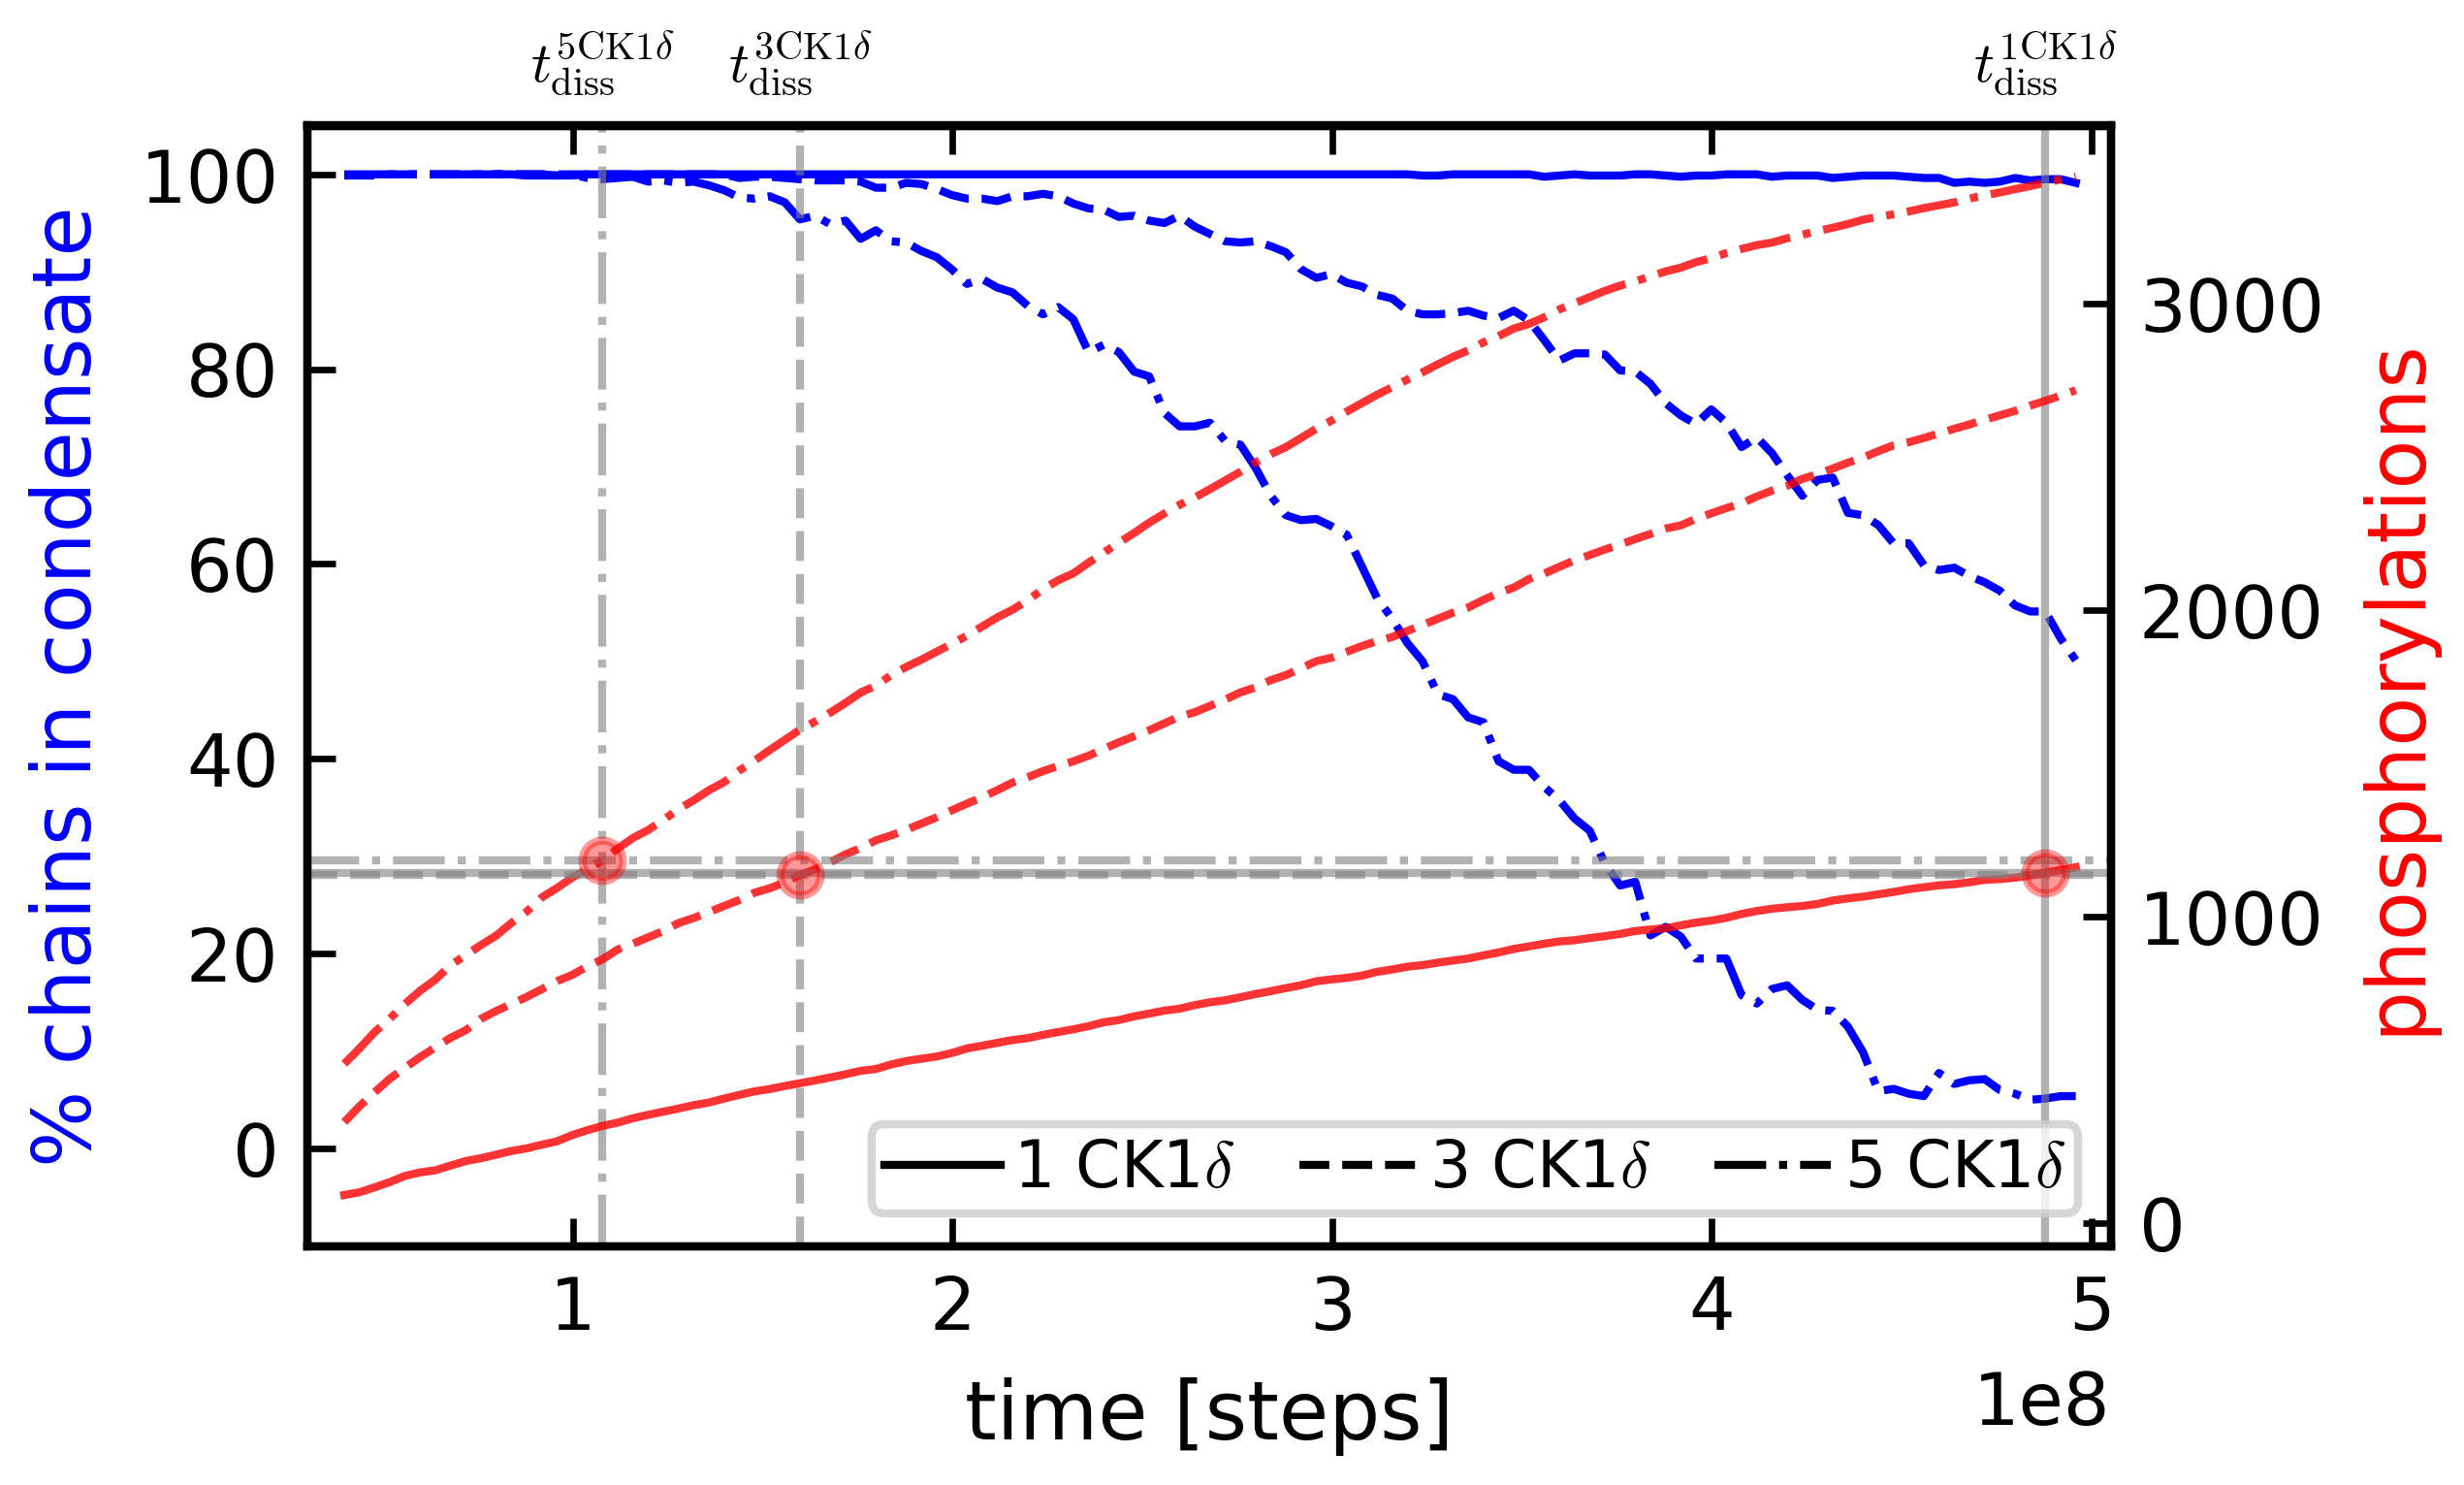

In [16]:
time_step = times*200000

fig, ax1 = plt.subplots(figsize=(4, 2.5))

# Plot the first array with the primary y-axis
ax1.plot(time_step[10:], nc_1ck1d[10:]/2, 'b')
ax1.plot(time_step, nc_3ck1d/2, 'b--')
ax1.plot(time_step, nc_5ck1d/2, 'b-.')
ax1.set_xlabel('time [steps]')
ax1.set_ylabel('% chains in condensate', color='b')
#ax1.tick_params(axis='y', labelcolor='b')
ax1.plot(time_step[0], nc_1ck1d[0]/2, 'k', label=r'1 CK1$\delta$')
ax1.plot(time_step[0], nc_1ck1d[0]/2, 'k--', label=r'3 CK1$\delta$')
ax1.plot(time_step[0], nc_1ck1d[0]/2, 'k-.', label=r'5 CK1$\delta$')

secax = ax1.secondary_xaxis('top')
secax.set_xticks([time_step[td_1], time_step[td_3], time_step[td_5]], ['$t^\mathrm{1CK1\delta}_\mathrm{diss}$','$t^\mathrm{3CK1\delta}_\mathrm{diss}$','$t^\mathrm{5CK1\delta}_\mathrm{diss}$'], fontsize='x-small' )
secax.tick_params(direction='in', color='grey' , length=0)

ax1.vlines([time_step[td_1], time_step[td_3], time_step[td_5]],ymin=-10,ymax=105, ls=['-','--','-.'] ,color='grey', linewidth=1, alpha=0.6)
ax1.set_ylim((-10,105))

# Create a secondary y-axis and plot the second array
ax2 = ax1.twinx()
ax2.plot(time_step, np_1ck1d,  'r', alpha=0.8)
ax2.plot(time_step, np_3ck1d, 'r--', alpha=0.8)
ax2.plot(time_step, np_5ck1d, 'r-.', alpha=0.8)
ax2.set_ylabel('phosphorylations', color='r')
#ax2.tick_params(axis='y')
ax2.hlines([np_1ck1d[td_1], np_3ck1d[td_3], np_5ck1d[td_5]],xmin=0.3*10**8,xmax=5.05*10**8, ls=['-','--','-.'], color='grey', linewidth=1, alpha=0.6)
ax2.set_xlim((0.3*10**8,5.05*10**8))

ax2.plot([time_step[td_1], time_step[td_3], time_step[td_5]], [np_1ck1d[td_1], np_3ck1d[td_3], np_5ck1d[td_5]], 'or', alpha=0.4, ms=5)

ax1.legend(ncols=3, loc='lower right')


In [17]:
ne_1ck1d = np.loadtxt(file+'enz_in_cond_1-folded-ck1d_multi-tdp43_sh.txt')
ne_3ck1d = np.loadtxt(file+'enz_in_cond_3-folded-ck1d_multi-tdp43_sh.txt')
ne_5ck1d = np.loadtxt(file+'enz_in_cond_5-folded-ck1d_multi-tdp43_sh.txt')

In [18]:
ne_1ck1d_np = np.loadtxt(file+'enz_in_cond_1-folded-ck1d_multi-tdp43_np.txt')
ne_3ck1d_np = np.loadtxt(file+'enz_in_cond_3-folded-ck1d_multi-tdp43_np.txt')
ne_5ck1d_np = np.loadtxt(file+'enz_in_cond_5-folded-ck1d_multi-tdp43_np.txt')

In [19]:
step = 10
times_sh = np.arange(0,500+step,step, dtype=int)-1

step = 20
times_np = np.arange(0,2450,step, dtype=int)-1
len(times_np)

123

In [20]:
np_1ck1d_sh = np.zeros(len(times_sh))
np_3ck1d_sh = np.zeros(len(times_sh))
np_5ck1d_sh = np.zeros(len(times_sh))
for i in [1,2,3,4]:
    tmp1 = nphospho_in_time(file+f'sim{i}_1-folded-ck1d_multi-tdp43_32b_dump.gsd', times_sh)
    tmp3 = nphospho_in_time(file+f'sim{i}_3-folded-ck1d_multi-tdp43_32b_dump.gsd', times_sh)
    tmp5 = nphospho_in_time(file+f'sim{i}_5-folded-ck1d_multi-tdp43_32b_dump.gsd', times_sh)
    np_1ck1d_sh += tmp1
    np_3ck1d_sh += tmp3
    np_5ck1d_sh += tmp5
    
np_1ck1d_sh /=4
np_3ck1d_sh /=4
np_5ck1d_sh /=4


2500
2500
2500
2500
2500
2500
2500
2500
2500
2500
2500
2500


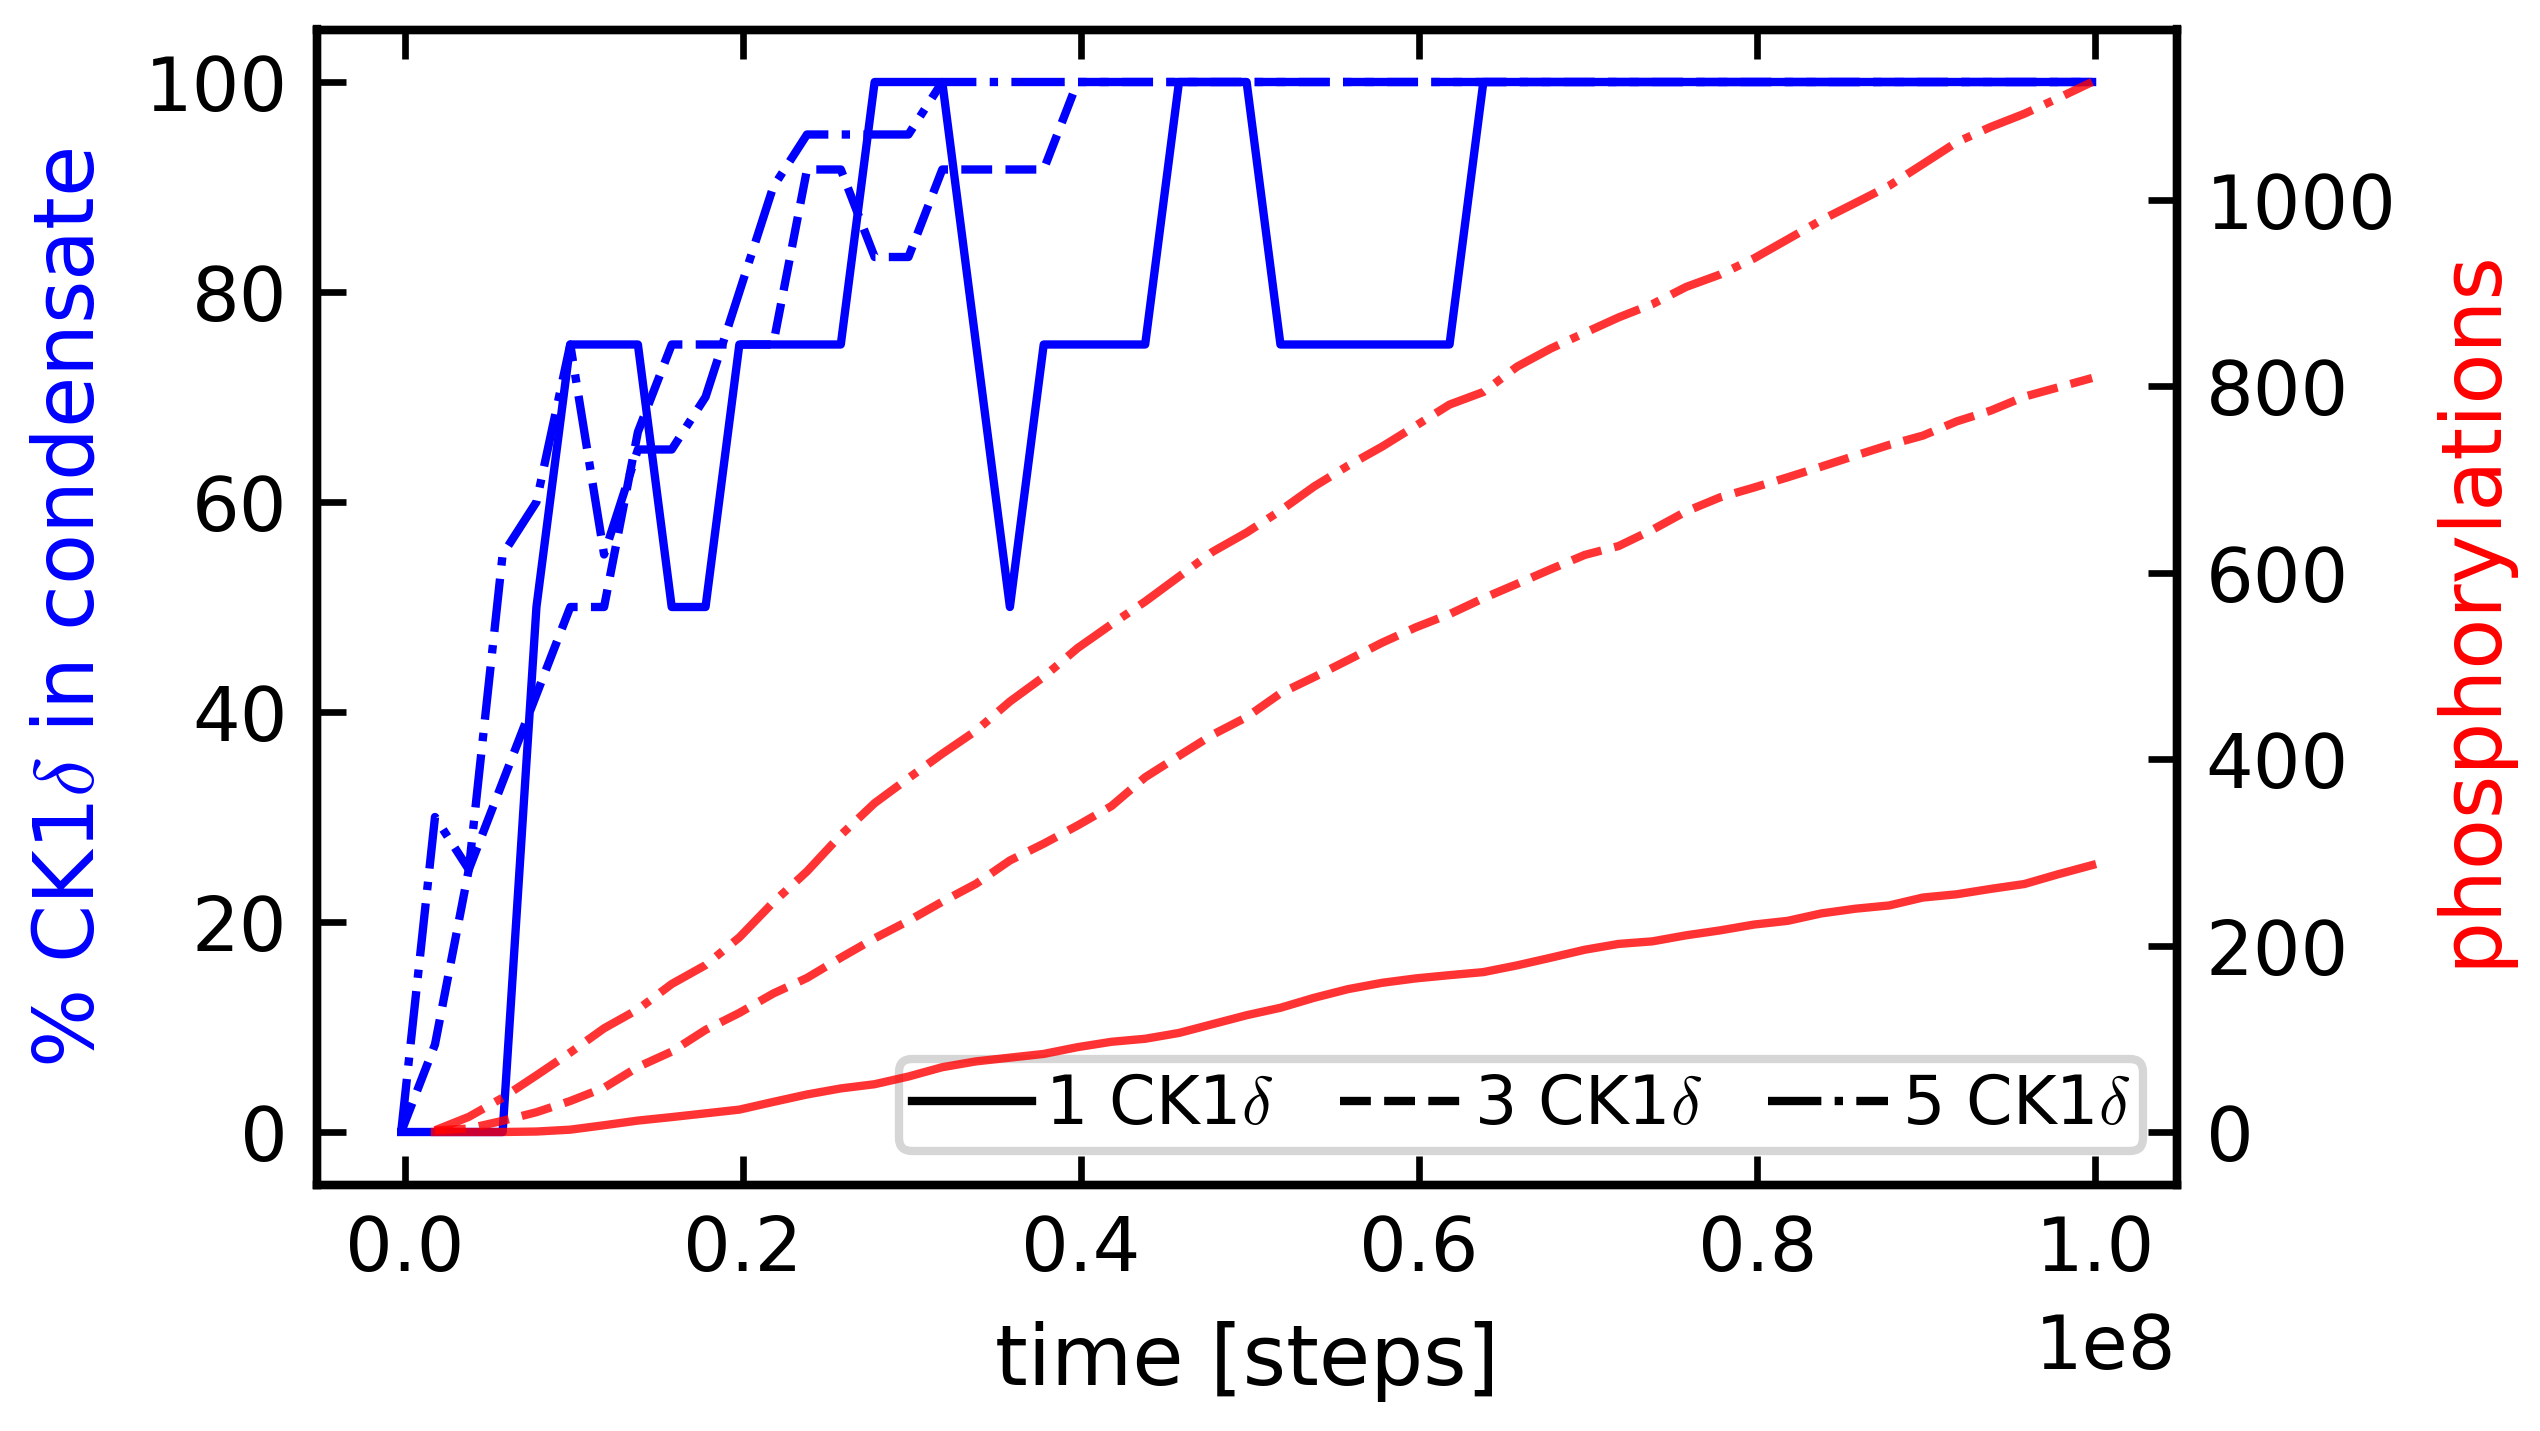

In [21]:
time_step_sh = times_sh*200000

fig, ax1 = plt.subplots(figsize=(4, 2.5))

# Plot the first array with the primary y-axis
ax1.plot(time_step_sh, ne_1ck1d*100, 'b')
ax1.plot(time_step_sh, ne_3ck1d/3*100, 'b--')
ax1.plot(time_step_sh, ne_5ck1d/5*100, 'b-.')
ax1.set_xlabel('time [steps]')
ax1.set_ylabel('% CK1$\delta$ in condensate', color='b')
ax1.plot(time_step_sh[0], ne_1ck1d[0]*100, 'k', label=r'1 CK1$\delta$')
ax1.plot(time_step_sh[0], ne_1ck1d[0]*100, 'k--', label=r'3 CK1$\delta$')
ax1.plot(time_step_sh[0], ne_1ck1d[0]*100, 'k-.', label=r'5 CK1$\delta$')


# Create a secondary y-axis and plot the second array
ax2 = ax1.twinx()
ax2.plot(time_step_sh[1:], np_1ck1d_sh[1:],  'r', alpha=0.8)
ax2.plot(time_step_sh[1:], np_3ck1d_sh[1:], 'r--', alpha=0.8)
ax2.plot(time_step_sh[1:], np_5ck1d_sh[1:], 'r-.', alpha=0.8)
ax2.set_ylabel('phosphorylations', color='r')

ax1.legend(ncols=3, loc='lower right')

(0.0, 509999999.99999994)

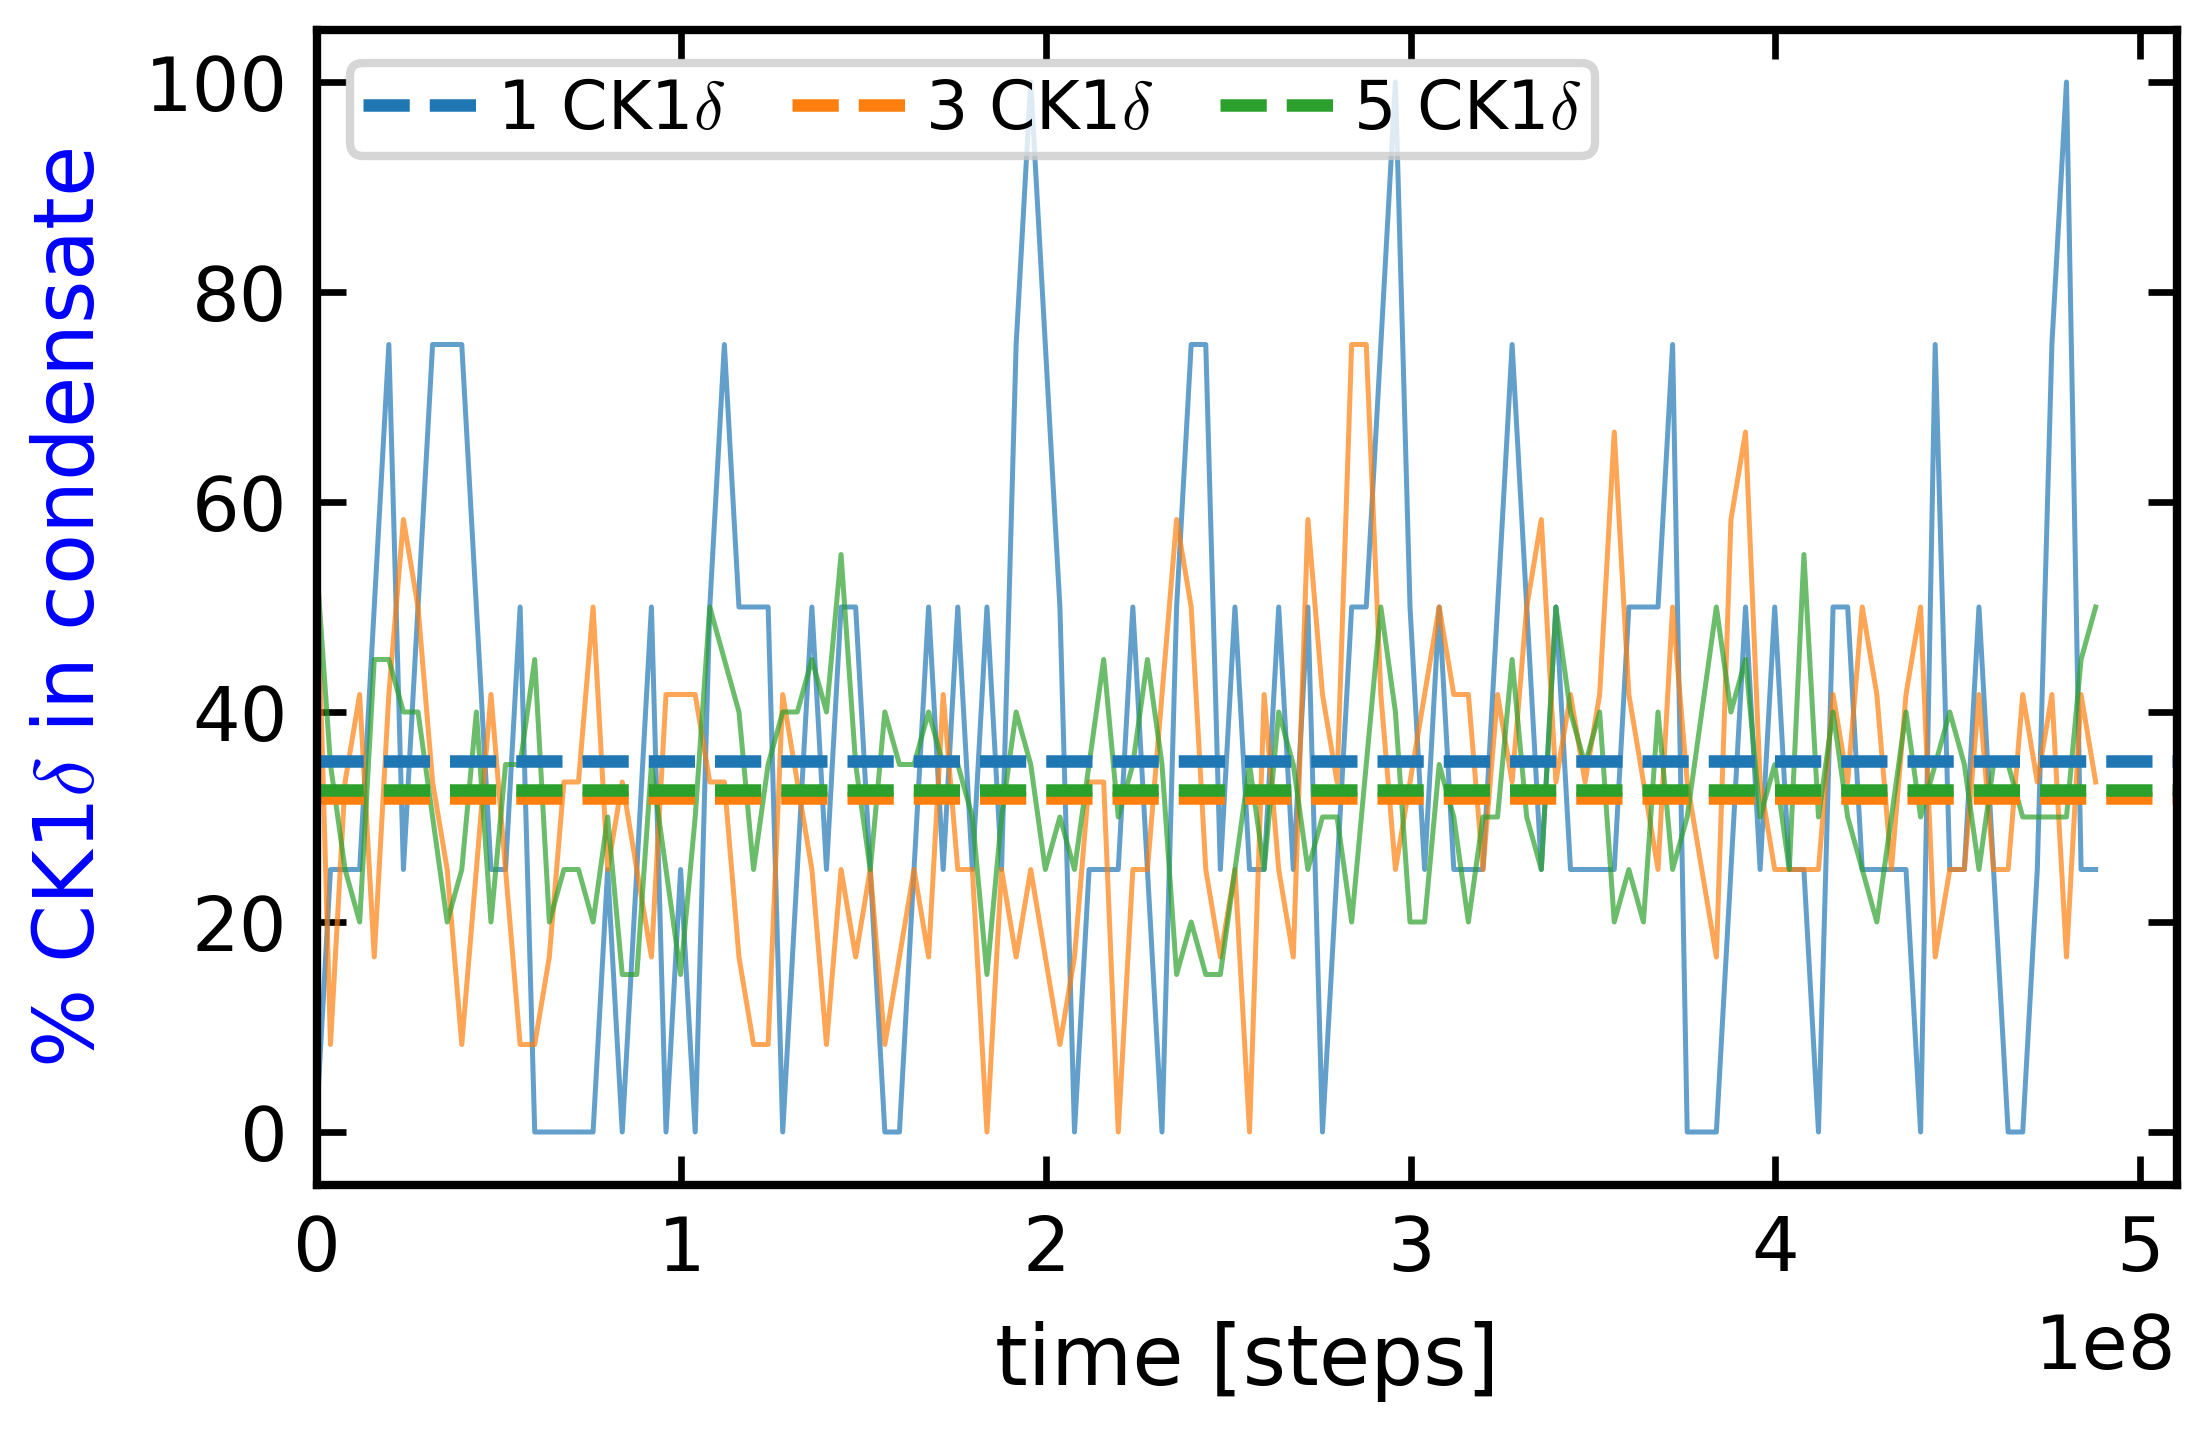

In [22]:
time_step_np = times_np*200000

fig, ax1 = plt.subplots(figsize=(4, 2.5))

# Plot the first array with the primary y-axis
ax1.plot(time_step_np, ne_1ck1d_np*100, 'tab:blue', alpha=0.7, lw=0.6)
ax1.plot(time_step_np, ne_3ck1d_np/3*100, 'tab:orange', alpha=0.7, lw=0.6)
ax1.plot(time_step_np, ne_5ck1d_np/5*100, 'tab:green', alpha=0.7, lw=0.6)
ax1.set_xlabel('time [steps]')
ax1.set_ylabel('% CK1$\delta$ in condensate', color='b')
ax1.plot([0*10**8,5.1*10**8], [np.mean(ne_1ck1d_np)*100]*2, '--', color='tab:blue', label=r'1 CK1$\delta$', lw=1.5)
ax1.plot([0*10**8,5.1*10**8], [np.mean(ne_3ck1d_np)/3*100]*2, '--', color='tab:orange', label=r'3 CK1$\delta$', lw=1.5)
ax1.plot([0*10**8,5.1*10**8], [np.mean(ne_5ck1d_np)/5*100]*2, '--', color='tab:green', label=r'5 CK1$\delta$', lw=1.5)

ax1.legend(ncols=3, loc='upper left')
ax1.set_xlim((0*10**8,5.1*10**8))
